In [1]:
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns
from skimage.segmentation import slic

In [2]:
!pip install torch_geometric
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00


In [3]:
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Dataset, Data, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from torch_geometric.utils import to_networkx



from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import NNConv, global_mean_pool
from torch_geometric.nn import GATConv
from skimage import io

In [4]:
chunk_size = 25

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)


In [5]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    vishak_max = vishak.max()
    vishak_min = vishak.min()
    vishak = (vishak - vishak_min)/(vishak_max - vishak_min)
    return vishak

In [6]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

In [7]:
def image_to_graph(image, patch_size=5, n_neighbors=5):
        """
        Convert an image to a graph of its 5x5 patches.

        Parameters:
        - image: A (125, 125, 3) numpy array.
        - patch_size: Size of the square patches (default 5).
        - n_neighbors: Number of neighbors for KNN (default 5).

        Returns:
        - nodes: An array of node features.
        - edges: A list of tuples (i, j, mse) representing edges and their MSE.
        """
        # Validate image shape
        
        assert image.shape[0] == image.shape[1], "Image must be square."

        # Number of patches along one dimension
        num_patches = image.shape[0] // patch_size

        # Initialize nodes and edges
        nodes = []
        edges = []

        # Create patches and flatten them to create node features
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :].reshape(-1)
                nodes.append(patch)

        nodes = np.array(nodes)

        # Use KNN to find nearest neighbors for each node
        nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(nodes)
        distances, indices = nbrs.kneighbors(nodes)

        # Calculate MSE for each pair of neighbors and create edges
        for i in range(indices.shape[0]):
            for j in range(1, indices.shape[1]):  # Start from 1 to skip self-connection
                mse = mean_squared_error(nodes[i], nodes[indices[i, j]])
                edges.append((i, indices[i, j], mse))

        return nodes, edges

In [8]:
class QuarkGluonDataset(Dataset):
    
    def __init__(self, dataframe, root='', transform=None, pre_transform=None):
        """
        Custom dataset for quarks and gluons classification.
        
        Parameters:
        - image_list: A list of (125, 125, 3) numpy arrays.
        - labels: A list of integers (0 or 1) representing the class labels for the images.
        """
        self.dataframe = dataframe
        super(QuarkGluonDataset, self).__init__(root, transform, pre_transform)
    
   
    def len(self):
        return len(self.dataframe)
    
    def get(self, idx):
        # Convert an image to graph data
        image = self.dataframe.iloc[idx]['X_jets']
        image = image.transpose(1,2,0)
        label = self.dataframe.iloc[idx]['y']
#         print(type(image))
        nodes, edges = image_to_graph(image)
        
        # Convert to PyTorch tensors
        x = torch.tensor(nodes, dtype=torch.float)  # Node features
        edge_index = torch.tensor([(i, j) for i, j, _ in edges], dtype=torch.long).t().contiguous()  # Edge indices
        edge_attr = torch.tensor([mse for _, _, mse in edges], dtype=torch.float).unsqueeze(1)  # Edge attributes
        y = torch.tensor([label], dtype=torch.long)  # Label
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [9]:
dataset = QuarkGluonDataset(data)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Perform the random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.nn import Linear, Dropout
import torch.nn.functional as F

class GraphSAGENet(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGENet, self).__init__()
        self.sage1 = SAGEConv(num_node_features, 512)
        self.sage2 = SAGEConv(512, 256)
        self.sage3 = SAGEConv(256, 128)
        self.dropout = Dropout(0.5)
        self.lin = Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.sage1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.sage2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.sage3(x, edge_index))

        x = global_mean_pool(x, batch)  # Pooling to use graph-level features
        x = self.dropout(x)
        x = self.lin(x)

        return x

# Initialize the GraphSAGE model
num_node_features = 75  # Adjust according to your dataset
num_classes = 2  # Assuming binary classification

model = GraphSAGENet(num_node_features=num_node_features, num_classes=num_classes)
model.load_state_dict(torch.load("/kaggle/input/fork-of-graphsage-final/best_model.pth"))
print(model)

GraphSAGENet(
  (sage1): SAGEConv(75, 512, aggr=mean)
  (sage2): SAGEConv(512, 256, aggr=mean)
  (sage3): SAGEConv(256, 128, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


# Loaded the weights that was already trained for 10 epochs and now trainning for more 5 epochs resulting in 15 epochs.

Using device: cuda


Saved Best Model: Epoch 1, Val. Acc.: 0.6987
Epoch: 001, Train Loss: 0.6180, Val. Loss: 0.5971, Val. Acc.: 0.6987


Saved Best Model: Epoch 2, Val. Acc.: 0.7112
Epoch: 002, Train Loss: 0.6076, Val. Loss: 0.5928, Val. Acc.: 0.7112


Epoch: 003, Train Loss: 0.6023, Val. Loss: 0.5854, Val. Acc.: 0.7004


Epoch: 004, Train Loss: 0.5938, Val. Loss: 0.5908, Val. Acc.: 0.7031


Epoch: 005, Train Loss: 0.5818, Val. Loss: 0.5908, Val. Acc.: 0.7112


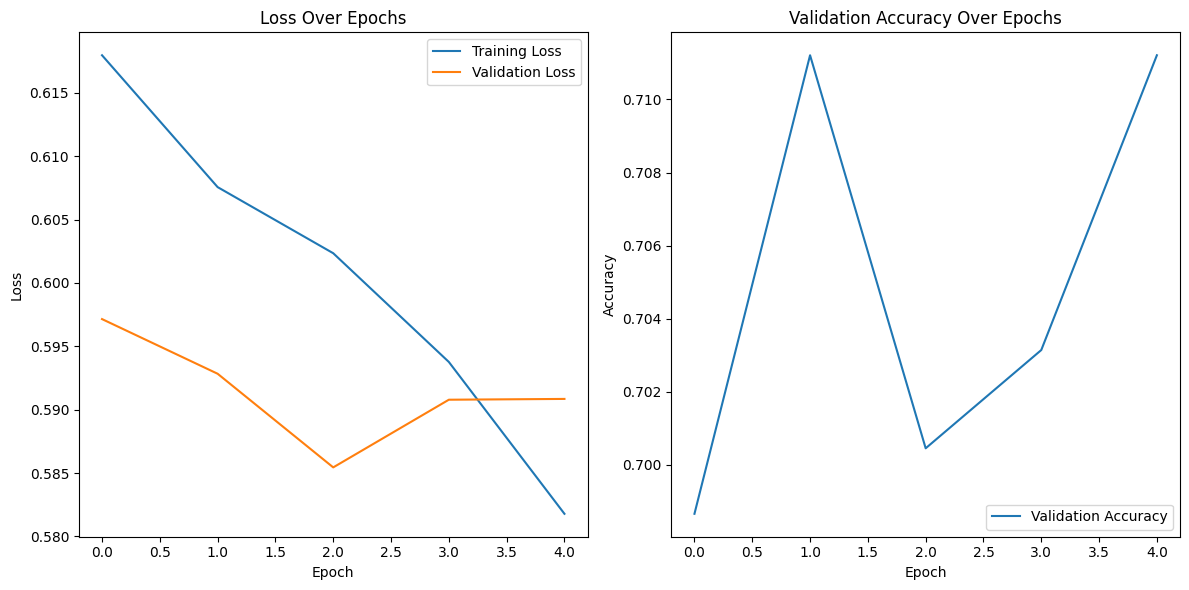

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Move the model to the chosen device
model.to(device)

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(model, loader, criterion, device):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad(), tqdm(loader, desc="Evaluating", leave=False) as tepoch:
        for data in tepoch:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    accuracy = correct / len(loader.dataset)
    return accuracy, total_loss / len(loader.dataset)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
for epoch in range(1, 6):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_acc, val_loss = test(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model: Epoch {epoch}, Val. Acc.: {val_acc:.4f}")
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val. Loss: {val_loss:.4f}, Val. Acc.: {val_acc:.4f}')

# Plotting the training curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()